In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline

## 오프라인/온라인 구별하지 않고 코로나 이후 소비가 급증한 업종 파악하기
- 데이터
    - 서울/대구 2019년 2, 3, 4, 5월 + 2020년 2, 3, 4, 5월
<br><br>


In [2]:
offline = pd.read_csv("../data/original_data/processed_data/CARD_SPENDING_RESIDENT_KOR.csv")
online  = pd.read_excel("../data/original_data/raw_data/05_물류데이터(CJ올리브네트웍스)/2020 빅콘테스트_CJ올리브네트웍스_제공DB.xlsx")

In [3]:
group_col = ['STD_DD', 'GU_CD', 'DONG_CD', 'MCT_CAT_CD']
offline = offline.groupby(group_col)[['USE_CNT', 'USE_AMT']].sum().reset_index()
offline['STD_DD'] = pd.to_datetime(offline['STD_DD'], format='%Y%m%d')

In [4]:
online['CTPV_NM'] = online['CTPV_NM'].replace("서울특별시", "서울")
online['CTPV_NM'] = online['CTPV_NM'].replace("대구광역시", "대구")
online['HDNG_NM'] = online['HDNG_NM'].replace("신당제5동", "신당5동") # 카드데이터와 일치시키기 위해서
online['CTGG_NM'] = online['CTPV_NM']+" "+online['CTGG_NM']
online['DL_YMD']  = pd.to_datetime(online['DL_YMD'], format='%y%m%d')
online = online[['DL_YMD', 'CTGG_NM', 'HDNG_NM', 'DL_GD_LCLS_NM', 'INVC_CONT']]

In [5]:
offline['YEAR_MONTH'] = offline['STD_DD'].dt.year*100 + offline['STD_DD'].dt.month
online['YEAR_MONTH']  = online['DL_YMD'].dt.year*100 + online['DL_YMD'].dt.month

**월별 USE_AMT의 합 추이**

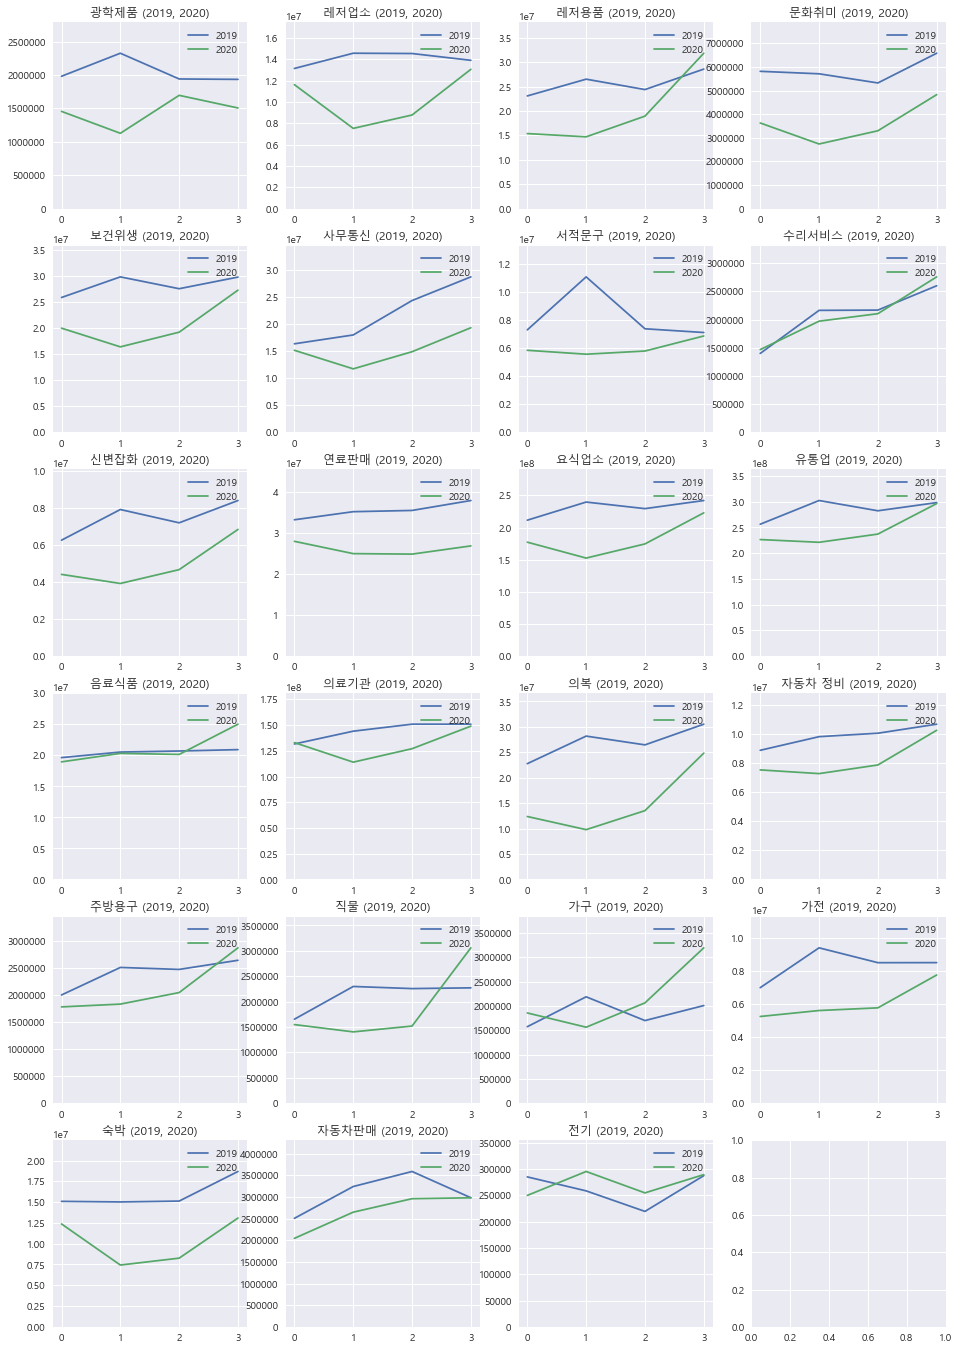

In [6]:
CATs = offline['MCT_CAT_CD'].unique()
offline_group_cat = offline.groupby(['MCT_CAT_CD', 'YEAR_MONTH'])[['USE_AMT']].sum().reset_index()

fig, axes = plt.subplots(nrows=len(CATs)//4+1, ncols=4, squeeze=False, figsize=(4*4, 4*(len(CATs)//4+1)))

for i, cat in enumerate(CATs):
    row = i//4
    col = i%4
    cat_df = offline_group_cat.loc[offline_group_cat['MCT_CAT_CD']==cat, :]
    cat_2019 = cat_df.loc[cat_df['YEAR_MONTH']<202000]
    cat_2020 = cat_df.loc[cat_df['YEAR_MONTH']>=202000]
    
    cat_2019[['USE_AMT']].reset_index(drop=True).plot(ax=axes[row][col])
    cat_2020[['USE_AMT']].reset_index(drop=True).plot(ax=axes[row][col])
    axes[row][col].set_ylim([0, cat_df['USE_AMT'].max()*1.2])
    axes[row][col].legend(['2019', '2020'], loc='upper right')
    axes[row][col].set_title("{} (2019, 2020)".format(cat))

In [7]:
offlineByCat = offline.groupby(['YEAR_MONTH', 'MCT_CAT_CD'])[['USE_CNT', 'USE_AMT']].sum().reset_index()
onlineByCat  = online.groupby(['YEAR_MONTH', 'DL_GD_LCLS_NM'])[['INVC_CONT']].sum().reset_index()

증가율 = (올해-전년)/(전년)

In [8]:
def DF_calculate_ratio(dataframe, category_column_name, year_month_column_name, numeric_column_name):
    CATs = dataframe[category_column_name].unique()
    df = pd.DataFrame()
    
    for cat in CATs:
        temp = dataframe.loc[(dataframe[category_column_name]==cat) & (dataframe[year_month_column_name] < 202000), :]
        if(temp.shape[0] != 4):
            print(cat, temp.shape[0])
            continue
        inc_2019_2_3, inc_2019_3_4, inc_2019_4_5 = \
            (temp[numeric_column_name] - temp[numeric_column_name].shift(1)).dropna().values / (temp[numeric_column_name][:3]).values

        temp = dataframe.loc[(dataframe[category_column_name]==cat) & (dataframe[year_month_column_name] > 202000), :]
        if(temp.shape[0] != 4):
            print(cat, temp.shape[0])
            continue
        inc_2020_2_3, inc_2020_3_4, inc_2020_4_5 = incr = \
            (temp[numeric_column_name] - temp[numeric_column_name].shift(1)).dropna().values / (temp[numeric_column_name][:3]).values

        df = df.append({
                         "CAT":cat,
                         "inc_2019_2_3":inc_2019_2_3, # 2019년 2월 대비 3월 증가율
                         "inc_2019_3_4":inc_2019_3_4, # 2019년 3월 대비 4월 증가율
                         "inc_2019_4_5":inc_2019_4_5, # 2019년 4월 대비 5월 증가율
                         "inc_2020_2_3":inc_2020_2_3, # 2020년 2월 대비 3월 증가율
                         "inc_2020_3_4":inc_2020_3_4, # 2020년 3월 대비 4월 증가율
                         "inc_2020_4_5":inc_2020_4_5} # 2020년 4월 대비 5월 증가율
            , ignore_index=True)
    return df

In [9]:
def calculate_fail_or_success(year_2019, year_2020):
    ratio = year_2020 / year_2019
    if(year_2019 < 0):
        # 2019년 감소
        if(ratio>1):
            # 2020년에 2019년보다 더 많이 감소하면 fail
            return "fail"
            # 2020년에 2019년보다 덜 감소하거나 오히려 증가하면 success
        else: 
            return "success"
    else:
        # 2019년 증가
        if(ratio>1): 
            # 2020년에 2019년보다 더 많이 증가하면 success
            return "success"
        else: 
            # 2020년에 2019년보다 덜 증가하거나 오히려 감소하면 fail
            return "fail"

In [10]:
def DF_fail_or_success(dataframe):
    BC_fail_or_success = []
    AC_fail_or_success = []

    for i in range(dataframe.shape[0]):
        before, after = dataframe.loc[i, ['inc_2019_2_3', 'inc_2020_2_3']]
        BC_fail_or_success.append(calculate_fail_or_success(before, after))

        before = dataframe.loc[i, ['inc_2019_3_4', 'inc_2019_4_5']].mean() # 2019년 3월 대비 4월, 4월 대비 5월 증가율의 평균
        after = dataframe.loc[i, ['inc_2020_3_4', 'inc_2020_4_5']].mean() # 2020년 3월 대비 4월, 4월 대비 5월 증가율의 평균
        AC_fail_or_success.append(calculate_fail_or_success(before, after))
        
    dataframe['BC_fail_or_success'] = BC_fail_or_success # 2월~3월 기간동안 성공/실패
    dataframe['AC_fail_or_success'] = AC_fail_or_success # 3월~5월 기간동안 성공/실패
    # 여기서 성공/실패란 유망하다면 성공, 유망하지 않다면 실패
    
    return dataframe

In [11]:
offline_ratio = DF_calculate_ratio(offlineByCat, "MCT_CAT_CD", "YEAR_MONTH", "USE_AMT")
offline_ratio = DF_fail_or_success(offline_ratio)

In [12]:
online_ratio = DF_calculate_ratio(onlineByCat, "DL_GD_LCLS_NM", "YEAR_MONTH", "INVC_CONT")
online_ratio = DF_fail_or_success(online_ratio)

### 코로나의 타격 없이 증가하는 업종

In [13]:
# 오프라인
# 오프라인에서 BC 기간에도 성장세로 판단되고, AC 기간에도 성장세로 판단되는 업종
# BC 기간 : 2월~3월
# AC 기간 : 3월~5월
offline_ratio.loc[(offline_ratio['BC_fail_or_success']=="success") & (offline_ratio['AC_fail_or_success']=="success"), 'CAT']

15     음료식품
19    자동차판매
Name: CAT, dtype: object

In [14]:
# 온라인
# 온라인에서 BC 기간에도 성장세로 판단되고, AC 기간에도 성장세로 판단되는 업종
online_ratio.loc[(online_ratio['BC_fail_or_success']=="success") & (online_ratio['AC_fail_or_success']=="success"), 'CAT']

0    가구/인테리어
2     디지털/가전
4     스포츠/레저
Name: CAT, dtype: object

## 시각화

In [15]:
def graph_offline_2019_2020(category_name):
    for_graph = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    for_graph = for_graph.groupby(['STD_DD', 'MCT_CAT_CD'])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    for_graph_2019 = for_graph.loc[for_graph['STD_DD'].apply(lambda x:x.year == 2019), :]
    for_graph_2020 = for_graph.loc[for_graph['STD_DD'].apply(lambda x:x.year == 2020), :]
    for_graph_2019['STD_DD'] = for_graph_2019['STD_DD'].apply(lambda x:x.replace(year=2020)) # for graph 
    
    ax = for_graph_2019.set_index('STD_DD')[['USE_AMT']].plot(figsize=(12, 5))
    for_graph_2020.set_index('STD_DD')[['USE_AMT']].plot(ax=ax)
    ax.legend(["2019", "2020"])
    ax.set_title("오프라인(신한카드) " + category_name)

In [16]:
def graph_online_2019_2020(category_name):
    for_graph = online.loc[online['DL_GD_LCLS_NM']==category_name, :]
    for_graph = for_graph.groupby(['DL_YMD', 'DL_GD_LCLS_NM'])[['INVC_CONT']].sum().reset_index()
    for_graph_2019 = for_graph.loc[for_graph['DL_YMD'].apply(lambda x:x.year == 2019), :]
    for_graph_2020 = for_graph.loc[for_graph['DL_YMD'].apply(lambda x:x.year == 2020), :]
    for_graph_2019['DL_YMD'] = for_graph_2019['DL_YMD'].apply(lambda x:x.replace(year=2020)) # for graph 
    
    ax = for_graph_2019.set_index('DL_YMD')[['INVC_CONT']].plot(figsize=(12, 5))
    for_graph_2020.set_index('DL_YMD')[['INVC_CONT']].plot(ax=ax)
    ax.legend(["2019", "2020"])
    ax.set_title("온라인(CJ물류) " + category_name)

## 1) 오프라인 유망

### 음료식품에 대한 탐구

- 음료식품은 2-3월에 코로나의 영향을 받지 X + 3-5월에 작년대비 소비량 증가하여 유망산업으로 뽑힘
- 작년 대비 소비량이 급증한 시점을 자세히 살펴보면 5월 15일 이라는 것을 확인할 수 있다.
- 즉, 재난지원금 지급일 (5월 13일) 이후 급격한 소비 증가는 재난지원금의 효과일 것으로 추정 가능하다.
- 즉, 재난지원금 효과로 유망식품으로 과대평가된 것으로 추정할 수 있다.

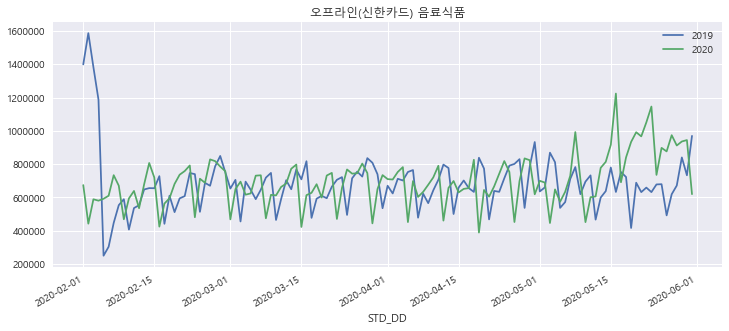

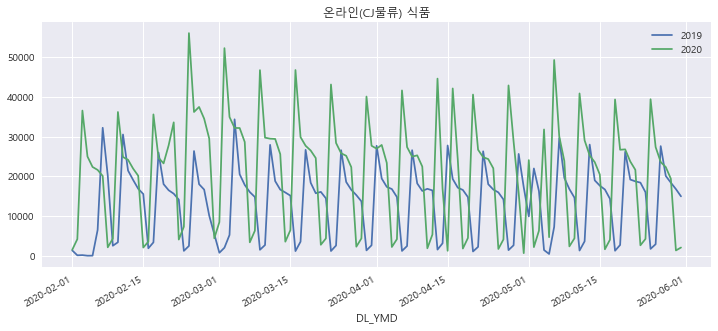

In [17]:
graph_offline_2019_2020("음료식품")
graph_online_2019_2020("식품")

### 자동차 판매에 대한 탐구
- 코로나의 영향을 거의 받지 않았다 (작년의 2월 대비 3월 증가율과 올해 2월 대비 3월 증가율이 거의 비슷)
- 그리고 작년 대비 자동차판매금액 증가율이 높다.
- 코로나로 대중교통 이용보다 자차 이용에 대한 선호도가 높아 이러한 결과가 나왔을 것으로 추측된다.
- 참고로 자동차 판매에는 중고차판매, 신차판매, 수입자동차, 중장비판매,수리, 오토바이가 포함되어 있다.

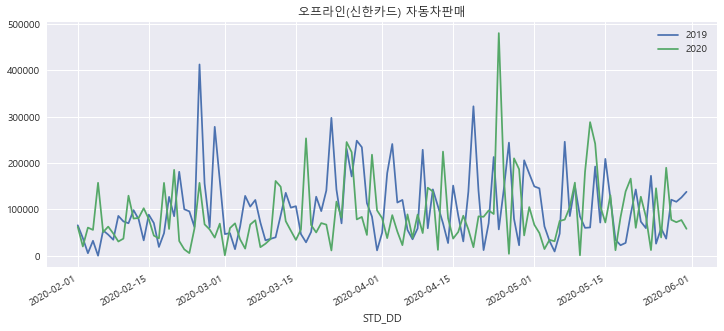

In [18]:
graph_offline_2019_2020("자동차판매")

## 2) 온라인 유망

### 가구 판매에 대한 탐구
- 가구같은 경우 코로나로 인한 타격이 거의 없어보인다
- 가구 지출액을 보면 5월 15일 이후 전년 동기간 대비 급증하고 있다!
- 재난지원금이 지급되기 시작한 5월 13일 이후에 이렇게 급증한 것을 보면, 재난지원금으로 인한 가구소비가 늘어난 것으로 추측
- 하지만 5월 15일 이전에도 전년 대비 소비금액이 많은 것을 보아 비교적 유망한 업종이라고 판단된다.

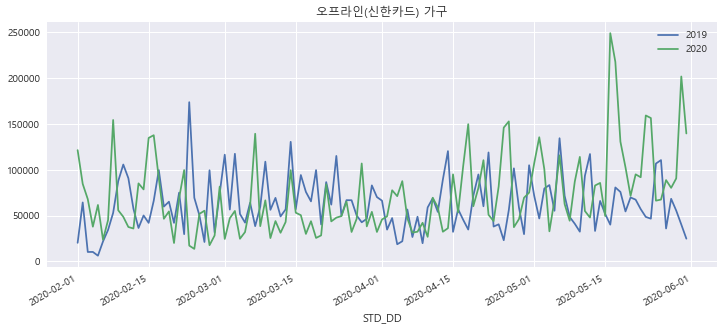

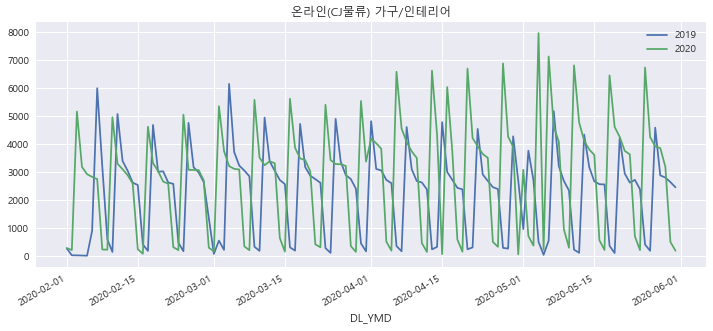

In [19]:
graph_offline_2019_2020("가구")
graph_online_2019_2020("가구/인테리어")

### 디지털/가전에 대한 탐구
- 오프라인에서의 소비는 2월 대비 3월 이전보다 감소추세 / 3월-4월, 4월-5월은 작년 대비 증가추세로 나왔다.
- 즉, 코로나 때 위축되었던 소비가 3월 이후에 증가한 것으로 판단된다.
- 온라인에서는 2월 대비 3월 소비 증가추세 / 3월-4월, 4월-5월은 작년 대비 증가추세로 나왔다.
- 오프라인에서 구매할 디지털/가전 소비가 온라인으로 옮겨갔다고 추측할 수 있으며,
- 또한 코로나 이후 집에 머무는 시간이 증가하며 온라인 디지털/가전 구매가 늘었을 것으로 예상된다.

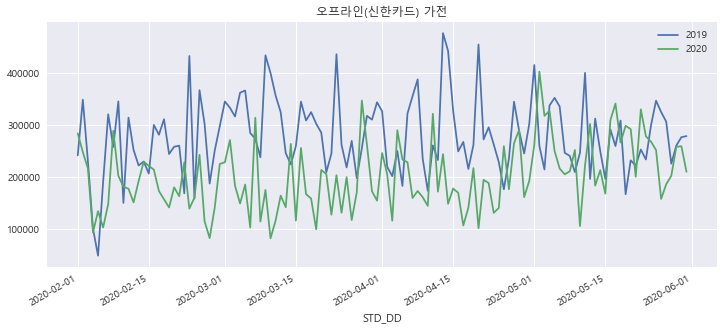

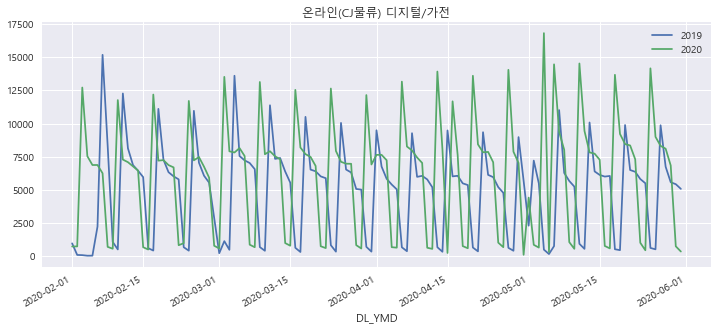

In [20]:
graph_offline_2019_2020("가전")
graph_online_2019_2020("디지털/가전")

### 레저는 코로나 유망 업종인가?
<br><br>
**<오프라인>**
- 레저업소 : 2020년에서 증가하는 추세이긴 하지만,코로나 이후 줄었던 소비가 회복하느라 증가하는 추세인 것으로 판단된다.
- 레저용품 : 2020년에 증가하는 추세이긴 하지만, 역시 코로나 이후 줄었던 소비가 회복되는 꼴로 보인다.
- 5월 15일 이후 레저용품 소비 급증 -> 재난 지원금의 효과로 추정된다 
<br><br>
**<온라인>**
- 온라인에서는 오프라인과 달리 거의 모든 기간에서 2019년 대비 2020년에 송장건수 많다!
- 코로나가 확산되기 시작한 2월에도 작년과 유사한 소비수준을 유지한 측면에서 코로나의 영향이 그다지 없었다
- 그 이후에도 작년보다 높은 소비수준을 보이며 소비가 늘었다고 판단할 수 있겠다.

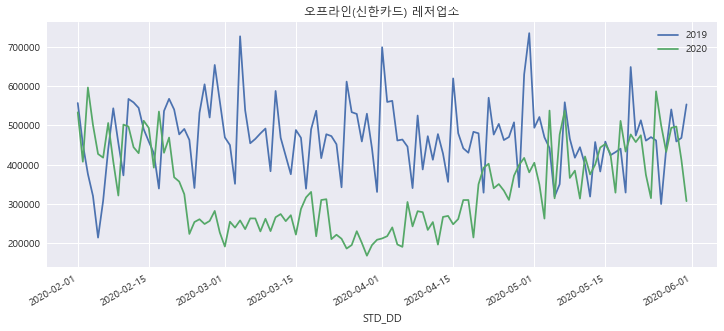

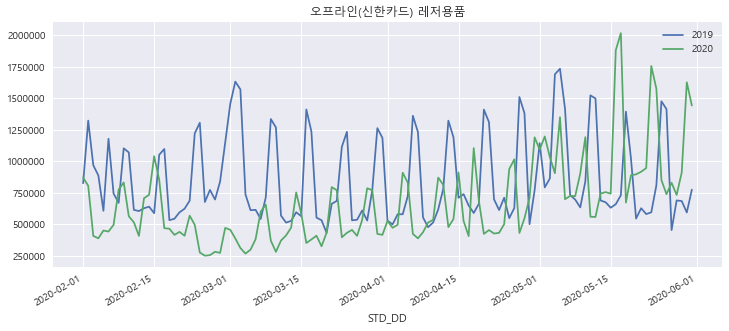

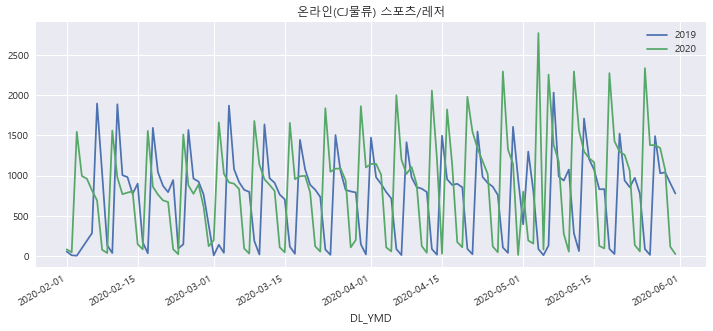

In [21]:
graph_offline_2019_2020("레저업소")
graph_offline_2019_2020("레저용품")
graph_online_2019_2020("스포츠/레저")